In [1]:
import tensorflow as tf
import nltk
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import pandas as pd

2025-06-26 09:47:12.270072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750924032.282859   16629 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750924032.286848   16629 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750924032.296414   16629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750924032.296429   16629 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750924032.296431   16629 computation_placer.cc:177] computation placer alr

In [2]:
from utils_display import pc

In [3]:
random.seed(421)

### Text, corpus, and vocabulary

In [4]:
# Text
with open("datasets/animal_farm_george_orwell.txt", "r") as fid:
    text = fid.read()

In [5]:
# Corpus
sentences = nltk.tokenize.sent_tokenize(text)
random.shuffle(sentences)

corpus = []
for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.findall(r'\b\w+\b', sentence) 
    corpus.append(sentence)

number_of_sentences = len(corpus)
pc("Number of sentences", number_of_sentences)

Number of sentences: 1637


In [6]:
train_split = 0.9
number_of_train_sentences = int(train_split * number_of_sentences)
number_of_validation_sentences = number_of_sentences - number_of_train_sentences
pc("Number of train sentences", number_of_train_sentences)
pc("Number of validation sentences", number_of_validation_sentences)

Number of train sentences: 1473
Number of validation sentences: 164


In [7]:
number_of_example_sentences = 4
for index in range(number_of_example_sentences):
    print(index)
    print(sentences[index])
    print(corpus[index])
    print("-"*64)

0
From now onwards Animal Farm would engage in trade with the neighbouring farms: not, of course, for any commercial purpose, but simply in order to obtain certain materials which were urgently necessary.
['from', 'now', 'onwards', 'animal', 'farm', 'would', 'engage', 'in', 'trade', 'with', 'the', 'neighbouring', 'farms', 'not', 'of', 'course', 'for', 'any', 'commercial', 'purpose', 'but', 'simply', 'in', 'order', 'to', 'obtain', 'certain', 'materials', 'which', 'were', 'urgently', 'necessary']
----------------------------------------------------------------
1
Finally there came a night when the gale was so violent that the farm buildings rocked on their foundations and several tiles were blown off the roof of the barn.
['finally', 'there', 'came', 'a', 'night', 'when', 'the', 'gale', 'was', 'so', 'violent', 'that', 'the', 'farm', 'buildings', 'rocked', 'on', 'their', 'foundations', 'and', 'several', 'tiles', 'were', 'blown', 'off', 'the', 'roof', 'of', 'the', 'barn']
-----------------

In [8]:
# Vocabulary
vocabulary = set([word for sentence in corpus for word in sentence])
vocabulary_size = len(vocabulary)
pc("Vocabulary size", vocabulary_size)

Vocabulary size: 3921


In [9]:
words_frequency = {}
for sentence in corpus:
    for word in sentence:
        if word in words_frequency:
            words_frequency[word] += 1
        else:
            words_frequency[word] = 1

words_frequency = sorted(words_frequency.items(), key=lambda x:x[1], reverse=True)
print(words_frequency)

[('the', 2211), ('and', 968), ('of', 902), ('to', 814), ('was', 633), ('a', 622), ('in', 544), ('had', 529), ('that', 453), ('it', 396), ('they', 345), ('he', 324), ('were', 290), ('his', 272), ('for', 264), ('animals', 248), ('on', 247), ('with', 231), ('at', 212), ('their', 197), ('as', 189), ('not', 184), ('but', 174), ('all', 174), ('be', 171), ('napoleon', 168), ('farm', 166), ('been', 162), ('them', 158), ('there', 142), ('would', 138), ('this', 138), ('which', 134), ('s', 134), ('snowball', 131), ('from', 129), ('by', 124), ('when', 118), ('out', 117), ('animal', 109), ('no', 102), ('boxer', 96), ('pigs', 93), ('said', 93), ('have', 91), ('who', 88), ('is', 87), ('now', 85), ('i', 85), ('jones', 83), ('up', 83), ('one', 79), ('you', 78), ('him', 77), ('could', 76), ('time', 76), ('an', 74), ('work', 72), ('more', 71), ('windmill', 71), ('two', 70), ('or', 69), ('squealer', 67), ('so', 64), ('down', 60), ('other', 60), ('after', 60), ('we', 59), ('every', 59), ('what', 58), ('eve

In [10]:
word2index = {word: index for index, word in enumerate(vocabulary)}
index2word = {index: word for index, word in enumerate(vocabulary)}

In [11]:
number_of_example_entries = 4
print("word2index")
print(list(word2index.items())[:number_of_example_entries])
print("index2word")
print(list(index2word.items())[:number_of_example_entries])

word2index
[('upside', 0), ('sat', 1), ('willingdon', 2), ('seen', 3)]
index2word
[(0, 'upside'), (1, 'sat'), (2, 'willingdon'), (3, 'seen')]


In [12]:
def generate_input_and_label_pairs(sequences, context_window):    
    context_and_target_pairs = []
    inputs = []
    labels = []
    for sequence in sequences:
        for i in range(context_window, len(sequence) - context_window):
            context = sequence[i - context_window : i] + sequence[i + 1 : i + context_window + 1]
            target = sequence[i]
            context_and_target_pairs.append((context, target))
        
            inputs.append([word2index[word] for word in context])
            labels.append(word2index[target])

    inputs = np.asarray(inputs)
    labels = np.asarray(labels)
    
    return context_and_target_pairs, inputs, labels

In [13]:
context_window = 2
train_data, train_inputs, train_labels = generate_input_and_label_pairs(
    sequences=corpus[:number_of_train_sentences], context_window=context_window)

validation_data, validation_inputs, validation_labels = generate_input_and_label_pairs(
    sequences=corpus[number_of_train_sentences:], context_window=context_window)

pc("Number of training samples", len(train_data))
pc("Number of validation samples", len(validation_data))

Number of training samples: 21647
Number of validation samples: 2317


In [14]:
number_of_examples = 4
for index in range(number_of_examples):
    print("Label: {:<3} {:20} Input: {} ({})".format(
        train_labels[index], train_data[index][1], train_inputs[index], train_data[index][0]))

Label: 3372 onwards              Input: [1223 2678 1240 1246] (['from', 'now', 'animal', 'farm'])
Label: 1240 animal               Input: [2678 3372 1246 1845] (['now', 'onwards', 'farm', 'would'])
Label: 1246 farm                 Input: [3372 1240 1845 3711] (['onwards', 'animal', 'would', 'engage'])
Label: 1845 would                Input: [1240 1246 3711 2850] (['animal', 'farm', 'engage', 'in'])


### Model

In [81]:
embedding_dim = 20

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(vocabulary_size, activation="softmax")])

In [82]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [83]:
number_of_epochs = 100
batch_size = 32

history = model.fit(
    train_inputs,
    train_labels,
    validation_data=(validation_inputs, validation_labels),
    epochs=number_of_epochs,
    batch_size=batch_size,
    verbose=False)

In [84]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 4, 20)          │        78,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 20)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3921)           │        82,341 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,285 (1.84 MB)

 Trainable params: 160,761 (627.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 321,524 (1.23 MB)

### Results

In [88]:
word_embeddings = model.get_weights()[0]
number_of_examples = 4
for index in range(number_of_examples):
    embedding = word_embeddings[index]
    word = index2word[index]
    pc(word, embedding)

upside: [-0.922995    2.4519835   2.0161433   2.0075037  -2.066271    0.824626
 -1.7158395  -1.97846     1.4825884   0.17773986  2.6744535   0.27572712
  0.45955268  2.2787433   1.887654    2.6264744   1.4648315   2.481525
 -2.6105578  -0.73810273]
sat: [ 0.16364133  0.40671334 -0.29786673 -0.40513644  1.8234572   0.6112556
 -2.0320756  -0.92086643 -1.6836625   0.07018247  0.08189753 -1.8625156
  0.7036481   0.5153761  -0.9703027   2.3577826   0.01998086  0.37340093
 -0.1298572   0.39503983]
willingdon: [-2.1992888   1.0718769   0.48481816  1.1014032   1.1812136   3.2830572
  1.3722835  -2.1076202  -0.735213   -1.3517225   1.0166482   0.58626854
  2.389032    0.6830353  -1.3334764  -0.28452197 -2.9228735   2.432299
  0.03533906 -0.79076135]
seen: [-3.377899   -0.24899006  1.2199477  -0.71391666 -0.2633321  -2.3282204
  0.81072444  0.2437665   1.5958321  -2.1608841   0.4523639   0.9409191
 -0.15045822  1.0110123  -1.128064   -0.53159827  0.45084164  0.3251565
 -0.52846175  0.6384499 ]


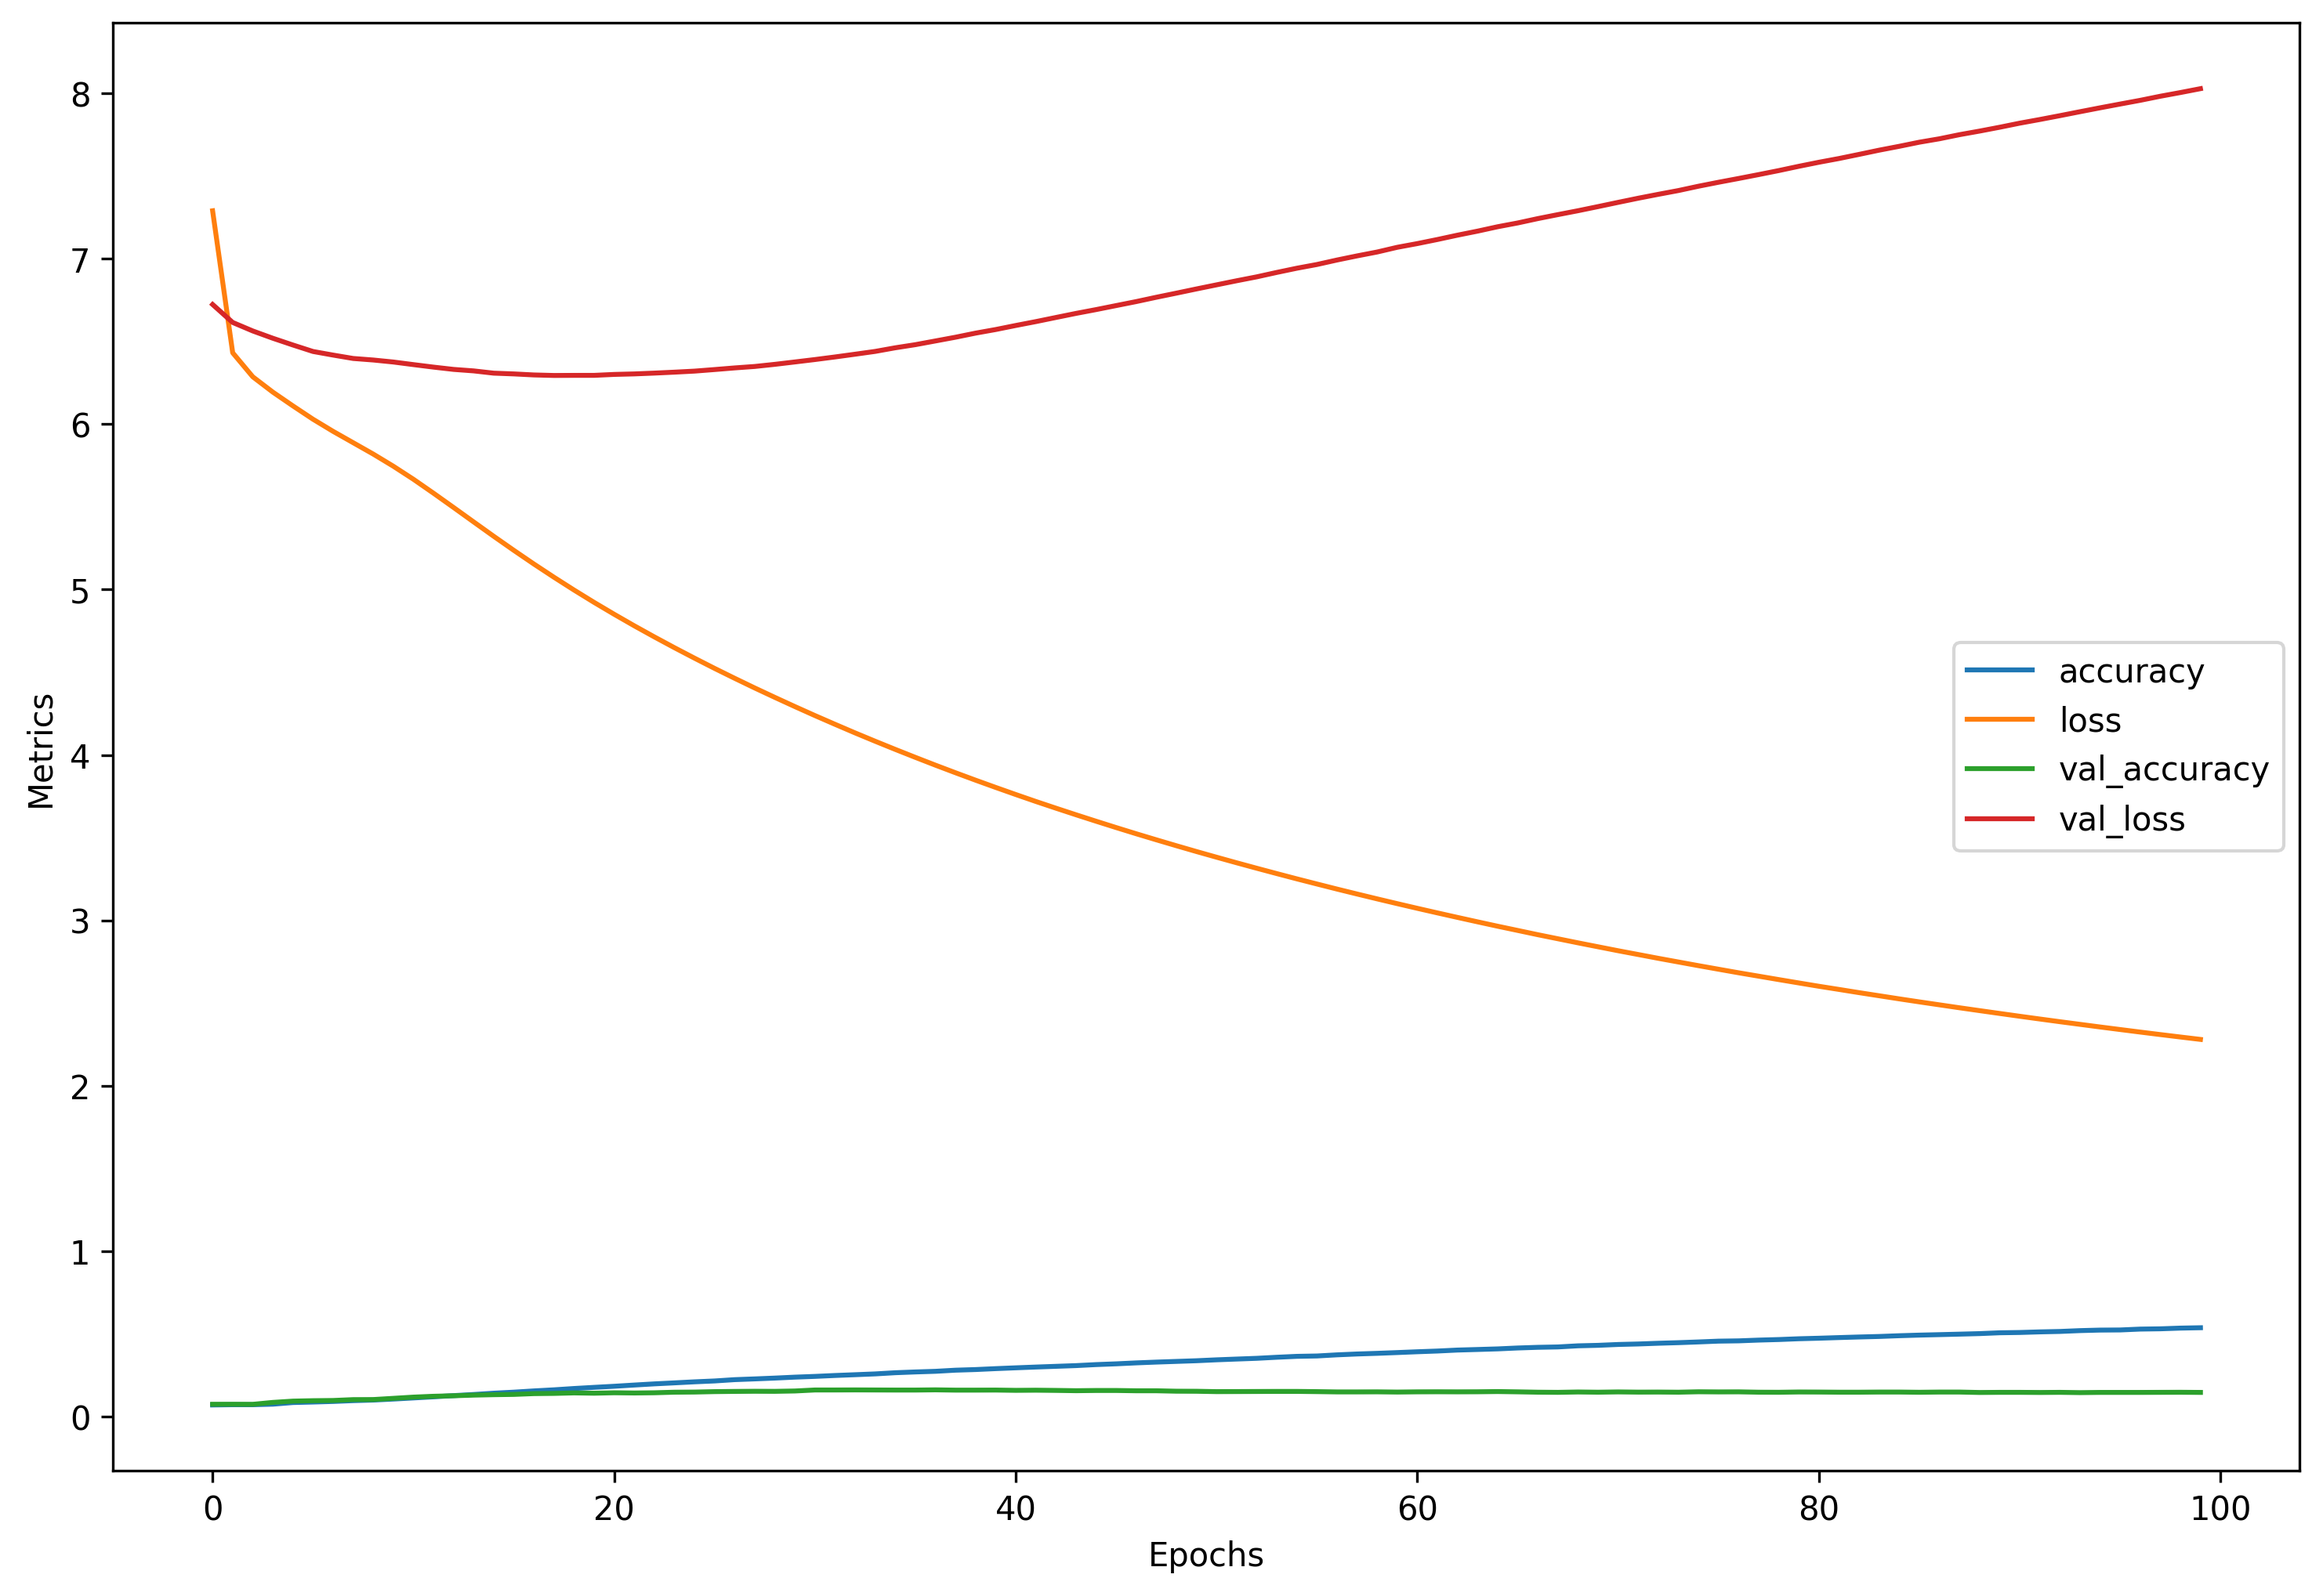

In [89]:
plt.rcParams["figure.dpi"] = 300
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()

In [99]:
index = 64

input_context = validation_inputs[index]
input_label = validation_labels[index]
input_context = np.expand_dims(input_context, axis=0)

predicted_labels = model.predict(input_context)[0]

pc("Index", index, break_line=True)

pc("Input context (indices)", input_context[0])
pc("Input context (words)", [index2word[i] for i in input_context[0]], break_line=True)

pc("Input label (index)", input_label)
pc("Input label (word)", index2word[input_label], break_line=True)

sorted_indices = np.argsort(-predicted_labels)
number_of_example = 4
for i in range(number_of_examples):
    vocabulary_index = sorted_indices[i]
    msg = "{} (index: {}, prediction strength: {:.2f}".format(
        index2word[vocabulary_index], vocabulary_index, predicted_labels[vocabulary_index])
    pc("Predicted word", msg)    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Index: 64

Input context (indices): [1900 1235 1172  438]
Input context (words): ['that', 'napoleon', 'to', 'sow']

Input label (index): 721
Input label (word): intended

Predicted word: himself (index: 2359, prediction strength: 0.07
Predicted word: frederick (index: 288, prediction strength: 0.06
Predicted word: advised (index: 617, prediction strength: 0.04
Predicted word: sell (index: 1555, prediction strength: 0.04


In [ ]:
y_max = np.max(predicted_labels)

plt.rcParams["figure.dpi"] = 300
plt.figure(figsize=(12, 8))
plt.plot([input_label, input_label], [0, y_max], color="cyan", linewidth=5, label="Target")
plt.plot(predicted_labels, color="crimson", label="Predictions")
plt.title("Prediction for input context: {}".format([index2word[i] for i in input_context[0]]))
plt.legend()
plt.xlabel("Vocabulary ({})".format(vocabulary_size))
plt.ylabel("Prediction strength")
plt.xlim(0, vocabulary_size)
plt.ylim(0, 1.05 * y_max)
plt.show()